In [120]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
load_dotenv()

WD = os.getenv('working_directory')

# TENSORFLOW

## CLOSE PRICE SEULEMENT, en 1d (Daily)

### PRE PROCESSING

In [121]:
# fonctions communes aux différents modèles

def load_data(name):
    """
    Load un dataframe depuis un fichier csv data/name.csv
    """
    return pd.read_csv(f'{WD}/data/{name}.csv') 

def get_date(df):
    return df['Open_time'].copy()

def df_to_numpy(df):
    return df.to_numpy()

def train_test_val(X, y, date, train_size):
    """
    """
    q_train_size = int(len(X)*train_size)
    q_val_test_size = int(len(X)*(train_size+(1-train_size)/2))

    X_train, y_train = X[:q_train_size], y[:q_train_size]
    X_val, y_val = X[q_train_size:q_val_test_size], y[q_train_size:q_val_test_size]
    X_test, y_test = X[q_val_test_size:], y[q_val_test_size:]

    date_numpy = df_to_numpy(date)
    date_train, date_val, date_test = date_numpy[:q_train_size], date_numpy[q_train_size:q_val_test_size], date_numpy[q_val_test_size:]
    return date_train, X_train, y_train, date_val, X_val, y_val, date_test, X_test, y_test

def main_pre_processing(name, is_one_var):
    """
    Renvoie X_train, y_train, X_val, y_val, X_test, y_test pour le df
    """
    df = load_data(name)
    date = get_date(df)
    if is_one_var:
        df = get_close_price(df)
        X, y, scaler_features, scaler_target = build_window_matrix_one_var(df, window_size=WINDOW_SIZE)
    else:
        df = rearrange_data(df)
        X, y, scaler_features, scaler_target = build_window_matrix_multi_var(df, window_size=WINDOW_SIZE)
    return train_test_val(X, y, date, train_size=0.8), scaler_features, scaler_target

In [122]:
## Fonctions propres au modèle pour 1 seule variable Close_price
def get_close_price(df):
    """
    Extrait seulement le prix de cloture de la journée
    """
    return df['Close_price'].copy()

def build_window_matrix_one_var(df, window_size):
    """
    """
    scaler = MinMaxScaler()

    df_numpy = df_to_numpy(df).reshape(len(df), -1)
    df_numpy_scaled = scaler.fit_transform(df_numpy)
    
    X = []
    y = []
    for i in range(len(df_numpy_scaled)-window_size):
        row = [a for a in df_numpy_scaled[i:i+window_size]]
        X.append(row)
        y.append(df_numpy_scaled[i+window_size])

    return np.array(X).astype(np.float32), np.array(y).astype(np.float32), scaler, scaler

#### Pre processing du dataframe dataset_raw_1d

In [123]:
data_name = "dataset_raw_1d"
is_one_var = True
WINDOW_SIZE = 7
(date_train, X_train, y_train, date_val, X_val, y_val, date_test, X_test, y_test), scaler_features, scaler_target = main_pre_processing(data_name, is_one_var)
print(f'X_train : {X_train.shape}')
print(f'y_train : {y_train.shape}')
print(f'X_val : {X_val.shape}')
print(f'y_val : {y_val.shape}')
print(f'X_test : {X_test.shape}')
print(f'y_test : {y_test.shape}')


X_train : (394, 7, 1)
y_train : (394, 1)
X_val : (49, 7, 1)
y_val : (49, 1)
X_test : (50, 7, 1)
y_test : (50, 1)


Format de X_train : 394 observations, 7 jours de données glissante, 1 variable Close_price

Format de y_train : 394 observations, 1 variable Close_price pour le (WINDOW_SIZE+1 : 8ème jour)

### TRAINING

In [124]:
## Fonctions communes aux différents modèles pour l'entrainement
def prepare_model(name, n_features):
    """
    Set up le model
    """
    # model = Sequential([Input((WINDOW_SIZE, n_features)),
    #                     LSTM(64),
    #                     Dense(32, activation='relu'),
    #                     Dense(32, activation='relu'),
    #                     Dense(1)
    #                     ], name=name)
    
    model = Sequential([Input((WINDOW_SIZE, n_features)),
                        LSTM(64),
                        Dense(32, activation='relu'),
                        Dense(32, activation='relu'),
                        Dense(32, activation='relu'),
                        Dense(1)
                        ], name=name)
    
    return model

def prepare_checkpoint(name):
    """
    """
    return ModelCheckpoint(f'{WD}/src/model/models/{name}/', save_best_only=True, save_format='tf', monitor='loss')

def train(model, learning_rate):
    """
    """
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=learning_rate), metrics=[RootMeanSquaredError()])
    return model

def fit(model, cp, X_train, y_train, X_val, y_val, N_EPOCHS):
    """
    """
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=N_EPOCHS, callbacks=[cp])
    return model

def main_training_model(model_name, scaler_features, scaler_target, X_train, y_train, X_val, y_val, N_EPOCHS):

    cp = prepare_checkpoint(name=model_name)
    model = prepare_model(name=model_name,n_features=X_train.shape[2])
    model = train(model, 0.001)
    model = fit(model, cp, X_train, y_train, X_val, y_val, N_EPOCHS)

#### Training du modèle Close_price-dataset_raw_1d-100

In [125]:
N_EPOCHS = 100
model_name = "Close_price"
data_name = "dataset_raw_1d"
full_model_name = model_name+'-'+data_name+'-'+str(N_EPOCHS)

main_training_model(full_model_name, scaler_features, scaler_target, X_train, y_train, X_val, y_val, N_EPOCHS)

Epoch 1/100
11/13 [========================>.....] - ETA: 0s - loss: 0.1287 - root_mean_squared_error: 0.3587

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 9s 539ms/step - loss: 0.1246 - root_mean_squared_error: 0.3531 - val_loss: 0.2288 - val_root_mean_squared_error: 0.4783
Epoch 2/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0477 - root_mean_squared_error: 0.2184

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 5s 419ms/step - loss: 0.0468 - root_mean_squared_error: 0.2164 - val_loss: 0.0209 - val_root_mean_squared_error: 0.1444
Epoch 3/100
13/13 [==============================] - ETA: 0s - loss: 0.0097 - root_mean_squared_error: 0.0986

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 5s 418ms/step - loss: 0.0097 - root_mean_squared_error: 0.0986 - val_loss: 0.0227 - val_root_mean_squared_error: 0.1505
Epoch 4/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0055 - root_mean_squared_error: 0.0742

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 6s 507ms/step - loss: 0.0055 - root_mean_squared_error: 0.0738 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0641
Epoch 5/100
11/13 [========================>.....] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0459

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 5s 432ms/step - loss: 0.0020 - root_mean_squared_error: 0.0451 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0571
Epoch 6/100
11/13 [========================>.....] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0330   

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 6s 457ms/step - loss: 0.0011 - root_mean_squared_error: 0.0333 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0524
Epoch 7/100
11/13 [========================>.....] - ETA: 0s - loss: 0.0010 - root_mean_squared_error: 0.0323

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 6s 514ms/step - loss: 0.0010 - root_mean_squared_error: 0.0319 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0574
Epoch 8/100
12/13 [==========================>...] - ETA: 0s - loss: 9.1603e-04 - root_mean_squared_error: 0.0303

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 5s 424ms/step - loss: 9.2376e-04 - root_mean_squared_error: 0.0304 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0684
Epoch 9/100
13/13 [==============================] - 0s 14ms/step - loss: 0.0010 - root_mean_squared_error: 0.0319 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0635
Epoch 10/100
13/13 [==============================] - 0s 14ms/step - loss: 9.5341e-04 - root_mean_squared_error: 0.0309 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0592
Epoch 11/100
11/13 [========================>.....] - ETA: 0s - loss: 8.7727e-04 - root_mean_squared_error: 0.0296

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 6s 465ms/step - loss: 8.5320e-04 - root_mean_squared_error: 0.0292 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0623
Epoch 12/100
13/13 [==============================] - 0s 14ms/step - loss: 8.7113e-04 - root_mean_squared_error: 0.0295 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0550
Epoch 13/100
13/13 [==============================] - ETA: 0s - loss: 8.2550e-04 - root_mean_squared_error: 0.0287

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 6s 518ms/step - loss: 8.2550e-04 - root_mean_squared_error: 0.0287 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0547
Epoch 14/100
13/13 [==============================] - 0s 14ms/step - loss: 8.4873e-04 - root_mean_squared_error: 0.0291 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0598
Epoch 15/100
12/13 [==========================>...] - ETA: 0s - loss: 8.2352e-04 - root_mean_squared_error: 0.0287

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 6s 470ms/step - loss: 8.1380e-04 - root_mean_squared_error: 0.0285 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0561
Epoch 16/100
12/13 [==========================>...] - ETA: 0s - loss: 8.0559e-04 - root_mean_squared_error: 0.0284

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 5s 441ms/step - loss: 7.9380e-04 - root_mean_squared_error: 0.0282 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0587
Epoch 17/100
12/13 [==========================>...] - ETA: 0s - loss: 7.9810e-04 - root_mean_squared_error: 0.0283

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 7s 571ms/step - loss: 7.9314e-04 - root_mean_squared_error: 0.0282 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0498
Epoch 18/100
13/13 [==============================] - 0s 15ms/step - loss: 8.3142e-04 - root_mean_squared_error: 0.0288 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0548
Epoch 19/100
11/13 [========================>.....] - ETA: 0s - loss: 7.7972e-04 - root_mean_squared_error: 0.0279

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 5s 437ms/step - loss: 7.5054e-04 - root_mean_squared_error: 0.0274 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0483
Epoch 20/100
13/13 [==============================] - 0s 14ms/step - loss: 8.4483e-04 - root_mean_squared_error: 0.0291 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0551
Epoch 21/100
13/13 [==============================] - 0s 14ms/step - loss: 7.8169e-04 - root_mean_squared_error: 0.0280 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0687
Epoch 22/100
13/13 [==============================] - 0s 14ms/step - loss: 8.4932e-04 - root_mean_squared_error: 0.0291 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0583
Epoch 23/100
13/13 [==============================] - 0s 15ms/step - loss: 8.2917e-04 - root_mean_squared_error: 0.0288 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0526
Epoch 24/100
11/13 [========================>.....] - ETA: 0s - loss: 7.3084e-04 - root_mean_squared_error: 0.0270

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 5s 445ms/step - loss: 7.2750e-04 - root_mean_squared_error: 0.0270 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0603
Epoch 25/100
13/13 [==============================] - ETA: 0s - loss: 7.0608e-04 - root_mean_squared_error: 0.0266

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 7s 546ms/step - loss: 7.0608e-04 - root_mean_squared_error: 0.0266 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0470
Epoch 26/100
13/13 [==============================] - 0s 16ms/step - loss: 8.0849e-04 - root_mean_squared_error: 0.0284 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0504
Epoch 27/100
13/13 [==============================] - 0s 14ms/step - loss: 7.2429e-04 - root_mean_squared_error: 0.0269 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0555
Epoch 28/100
13/13 [==============================] - 0s 14ms/step - loss: 7.8286e-04 - root_mean_squared_error: 0.0280 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0673
Epoch 29/100
13/13 [==============================] - 0s 15ms/step - loss: 7.7416e-04 - root_mean_squared_error: 0.0278 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0740
Epoch 30/100
13/13 [==============================] - 0s 17ms/step - loss: 7.9842e-04 - root_mean_squared_error: 0.0283 - val_l

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 5s 422ms/step - loss: 6.9651e-04 - root_mean_squared_error: 0.0264 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0606
Epoch 33/100
13/13 [==============================] - 0s 14ms/step - loss: 7.1006e-04 - root_mean_squared_error: 0.0266 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0692
Epoch 34/100
13/13 [==============================] - 0s 13ms/step - loss: 7.3150e-04 - root_mean_squared_error: 0.0270 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0634
Epoch 35/100
13/13 [==============================] - ETA: 0s - loss: 6.6127e-04 - root_mean_squared_error: 0.0257

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 5s 411ms/step - loss: 6.6127e-04 - root_mean_squared_error: 0.0257 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0673
Epoch 36/100
13/13 [==============================] - 0s 14ms/step - loss: 7.2474e-04 - root_mean_squared_error: 0.0269 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0524
Epoch 37/100
12/13 [==========================>...] - ETA: 0s - loss: 6.5227e-04 - root_mean_squared_error: 0.0255

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 6s 505ms/step - loss: 6.4031e-04 - root_mean_squared_error: 0.0253 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0581
Epoch 38/100
11/13 [========================>.....] - ETA: 0s - loss: 6.1066e-04 - root_mean_squared_error: 0.0247

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 5s 417ms/step - loss: 6.3392e-04 - root_mean_squared_error: 0.0252 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0559
Epoch 39/100
12/13 [==========================>...] - ETA: 0s - loss: 6.3211e-04 - root_mean_squared_error: 0.0251

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 6s 484ms/step - loss: 6.2225e-04 - root_mean_squared_error: 0.0249 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0528
Epoch 40/100
13/13 [==============================] - 0s 15ms/step - loss: 6.3936e-04 - root_mean_squared_error: 0.0253 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0558
Epoch 41/100
13/13 [==============================] - 0s 14ms/step - loss: 6.4634e-04 - root_mean_squared_error: 0.0254 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0613
Epoch 42/100
13/13 [==============================] - 0s 15ms/step - loss: 6.5330e-04 - root_mean_squared_error: 0.0256 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0572
Epoch 43/100
13/13 [==============================] - ETA: 0s - loss: 5.9041e-04 - root_mean_squared_error: 0.0243

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 5s 446ms/step - loss: 5.9041e-04 - root_mean_squared_error: 0.0243 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0649
Epoch 44/100
13/13 [==============================] - ETA: 0s - loss: 5.7978e-04 - root_mean_squared_error: 0.0241

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 5s 429ms/step - loss: 5.7978e-04 - root_mean_squared_error: 0.0241 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0541
Epoch 45/100
12/13 [==========================>...] - ETA: 0s - loss: 5.7893e-04 - root_mean_squared_error: 0.0241

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 7s 585ms/step - loss: 5.7444e-04 - root_mean_squared_error: 0.0240 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0471
Epoch 46/100
12/13 [==========================>...] - ETA: 0s - loss: 5.7894e-04 - root_mean_squared_error: 0.0241

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 5s 439ms/step - loss: 5.7361e-04 - root_mean_squared_error: 0.0240 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0560
Epoch 47/100
11/13 [========================>.....] - ETA: 0s - loss: 5.5786e-04 - root_mean_squared_error: 0.0236

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 5s 439ms/step - loss: 5.5912e-04 - root_mean_squared_error: 0.0236 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0466
Epoch 48/100
13/13 [==============================] - 0s 13ms/step - loss: 5.6477e-04 - root_mean_squared_error: 0.0238 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0483
Epoch 49/100
11/13 [========================>.....] - ETA: 0s - loss: 5.3348e-04 - root_mean_squared_error: 0.0231

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 7s 569ms/step - loss: 5.3442e-04 - root_mean_squared_error: 0.0231 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0464
Epoch 50/100
13/13 [==============================] - 0s 14ms/step - loss: 5.9251e-04 - root_mean_squared_error: 0.0243 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0635
Epoch 51/100
13/13 [==============================] - 0s 14ms/step - loss: 6.2447e-04 - root_mean_squared_error: 0.0250 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0493
Epoch 52/100
13/13 [==============================] - 0s 14ms/step - loss: 5.7751e-04 - root_mean_squared_error: 0.0240 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0646
Epoch 53/100
13/13 [==============================] - 0s 14ms/step - loss: 5.5625e-04 - root_mean_squared_error: 0.0236 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0473
Epoch 54/100
12/13 [==========================>...] - ETA: 0s - loss: 4.8749e-04 - root_mean_squared_error: 0.0221

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 6s 464ms/step - loss: 4.8986e-04 - root_mean_squared_error: 0.0221 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0498
Epoch 55/100
13/13 [==============================] - ETA: 0s - loss: 4.8628e-04 - root_mean_squared_error: 0.0221

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 6s 459ms/step - loss: 4.8628e-04 - root_mean_squared_error: 0.0221 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0481
Epoch 56/100
12/13 [==========================>...] - ETA: 0s - loss: 4.5033e-04 - root_mean_squared_error: 0.0212

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 7s 545ms/step - loss: 4.6790e-04 - root_mean_squared_error: 0.0216 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0638
Epoch 57/100
13/13 [==============================] - 0s 14ms/step - loss: 5.9416e-04 - root_mean_squared_error: 0.0244 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0503
Epoch 58/100
13/13 [==============================] - 0s 15ms/step - loss: 5.3309e-04 - root_mean_squared_error: 0.0231 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0592
Epoch 59/100
13/13 [==============================] - 0s 14ms/step - loss: 5.5288e-04 - root_mean_squared_error: 0.0235 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0475
Epoch 60/100
13/13 [==============================] - 0s 14ms/step - loss: 4.9403e-04 - root_mean_squared_error: 0.0222 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0454
Epoch 61/100
13/13 [==============================] - 0s 13ms/step - loss: 4.9509e-04 - root_mean_squared_error: 0.0223 - val_l

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 5s 428ms/step - loss: 4.5245e-04 - root_mean_squared_error: 0.0213 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0483
Epoch 63/100
13/13 [==============================] - 0s 14ms/step - loss: 4.7211e-04 - root_mean_squared_error: 0.0217 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0437
Epoch 64/100
13/13 [==============================] - 0s 15ms/step - loss: 5.3393e-04 - root_mean_squared_error: 0.0231 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0567
Epoch 65/100
13/13 [==============================] - 0s 14ms/step - loss: 6.2115e-04 - root_mean_squared_error: 0.0249 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0635
Epoch 66/100
13/13 [==============================] - 0s 15ms/step - loss: 5.9608e-04 - root_mean_squared_error: 0.0244 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0522
Epoch 67/100
13/13 [==============================] - 0s 15ms/step - loss: 7.0663e-04 - root_mean_squared_error: 0.0266 - val_l

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 5s 445ms/step - loss: 4.2593e-04 - root_mean_squared_error: 0.0206 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0459
Epoch 78/100
13/13 [==============================] - 0s 14ms/step - loss: 4.6375e-04 - root_mean_squared_error: 0.0215 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0508
Epoch 79/100
13/13 [==============================] - 0s 15ms/step - loss: 4.3716e-04 - root_mean_squared_error: 0.0209 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0479
Epoch 80/100
13/13 [==============================] - 0s 14ms/step - loss: 4.2713e-04 - root_mean_squared_error: 0.0207 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0430
Epoch 81/100
13/13 [==============================] - ETA: 0s - loss: 4.2159e-04 - root_mean_squared_error: 0.0205

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 6s 526ms/step - loss: 4.2159e-04 - root_mean_squared_error: 0.0205 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0428
Epoch 82/100
13/13 [==============================] - 0s 15ms/step - loss: 4.5625e-04 - root_mean_squared_error: 0.0214 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0500
Epoch 83/100
13/13 [==============================] - 0s 15ms/step - loss: 4.3291e-04 - root_mean_squared_error: 0.0208 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0402
Epoch 84/100
13/13 [==============================] - 0s 15ms/step - loss: 5.8559e-04 - root_mean_squared_error: 0.0242 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0550
Epoch 85/100
13/13 [==============================] - 0s 14ms/step - loss: 6.6148e-04 - root_mean_squared_error: 0.0257 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0510
Epoch 86/100
13/13 [==============================] - 0s 15ms/step - loss: 5.5573e-04 - root_mean_squared_error: 0.0236 - val_l

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 5s 419ms/step - loss: 4.1939e-04 - root_mean_squared_error: 0.0205 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0419
Epoch 91/100
13/13 [==============================] - 0s 14ms/step - loss: 4.2800e-04 - root_mean_squared_error: 0.0207 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0471
Epoch 92/100
12/13 [==========================>...] - ETA: 0s - loss: 4.1249e-04 - root_mean_squared_error: 0.0203

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 6s 490ms/step - loss: 4.0584e-04 - root_mean_squared_error: 0.0201 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0493
Epoch 93/100
13/13 [==============================] - 0s 15ms/step - loss: 4.2349e-04 - root_mean_squared_error: 0.0206 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0448
Epoch 94/100
13/13 [==============================] - 0s 14ms/step - loss: 4.1127e-04 - root_mean_squared_error: 0.0203 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0420
Epoch 95/100
12/13 [==========================>...] - ETA: 0s - loss: 4.0547e-04 - root_mean_squared_error: 0.0201

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 6s 511ms/step - loss: 4.0108e-04 - root_mean_squared_error: 0.0200 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0520
Epoch 96/100
13/13 [==============================] - 0s 14ms/step - loss: 4.6029e-04 - root_mean_squared_error: 0.0215 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0405
Epoch 97/100
13/13 [==============================] - 0s 16ms/step - loss: 4.0546e-04 - root_mean_squared_error: 0.0201 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0405
Epoch 98/100
13/13 [==============================] - 0s 15ms/step - loss: 4.1027e-04 - root_mean_squared_error: 0.0203 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0507
Epoch 99/100
13/13 [==============================] - 0s 14ms/step - loss: 4.2462e-04 - root_mean_squared_error: 0.0206 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0444
Epoch 100/100
12/13 [==========================>...] - ETA: 0s - loss: 3.9113e-04 - root_mean_squared_error: 0.0198

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 5s 437ms/step - loss: 3.9328e-04 - root_mean_squared_error: 0.0198 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0468


### ANALYSE DES RÉSULTATS

In [126]:
# Fonctions communes aux différentes modèles
def create_directory_if_not_exists(directory_name):
    """
    Crée un répertoire s'il n'existe pas déjà.

    Parameters:
    directory_name (str): Le nom du répertoire à créer.
    """
    if not os.path.exists(directory_name):
        try:
            os.makedirs(directory_name)
            print(f"Répertoire '{directory_name}' créé avec succès.")
        except Exception as e:
            print(f"Erreur lors de la création du répertoire '{directory_name}': {e}")
    else:
        print(f"Le répertoire '{directory_name}' existe déjà.")


def load(name):
    """
    """
    return load_model(f'{WD}/src/model/models/{name}/', custom_objects={'LSTM': LSTM})

def predict(model, X):
    """
    """
    return model.predict(X)

def inverse_scaler(scaler, array):
    """
    """
    return scaler.inverse_transform(array)

def plot(df, model_name, is_train):
    """
    """
    ticks_to_display = np.linspace(0, len(df) - 1, 5, dtype=int)  # 5 indices répartis uniformément
    create_directory_if_not_exists(f'{WD}/figure/{model_name}')
    plt.clf()
    plt.plot(df['Date'], df['Actual N+1'], label='Actuals') 
    plt.plot(df['Date'], df['Predictions N+1'], label='Predictions')
    plt.xticks(ticks_to_display, df["Date"].iloc[ticks_to_display], rotation=45)
    plt.title(f"Comparaison Réel et Prédiction pour le jeu de {'train' if is_train==1 else 'test' if is_train==0 else 'validation'}")
    plt.legend()
    plt.show()
    plt.savefig(f"{WD}/figure/{model_name}/COMPARAISON_{'train_' if is_train==1 else 'test_' if is_train==0 else 'val_'}prediction.png")

In [127]:
## Fonctions propres au modèle pour 1 seule variable Close_price en Daily
def analyze(date, X, y, predictions):
    """
    """
    df_analyze = pd.concat([
                            pd.DataFrame(date), 
                            pd.DataFrame(X[:, WINDOW_SIZE-1, 0]), 
                            pd.DataFrame(y.reshape(-1)), 
                            pd.DataFrame(predictions)
                            ], axis=1)



    df_analyze.columns = ['Date', 'Actual N', 'Actual N+1', 'Predictions N+1']

    df_analyze['Actual UP or DOWN'] = pd.DataFrame((df_analyze['Actual N+1'] > df_analyze['Actual N']).astype(int))
    df_analyze['Predicted UP or DOWN'] = pd.DataFrame((df_analyze['Predictions N+1'] > df_analyze['Actual N']).astype(int))

    cm = confusion_matrix(df_analyze['Actual UP or DOWN'], df_analyze['Predicted UP or DOWN'])
    acc = cm[0][0] + cm[1][1]
    tot = cm.sum()
    print(f'Accuracy : {acc/tot*100}%')
    cm_df = pd.DataFrame(cm, index=['Actual DOWN', 'Actual UP'], columns=['Predicted DOWN', 'Predicted UP'])
    
    return df_analyze, cm_df

def analyze_for_data(model, scaler_features, scaler_target, date_train, X_train, y_train, date_test, X_test, y_test, date_val, X_val, y_val, is_train):

    if is_train==1:
        date = date_train
        X = X_train
        y = y_train
    elif is_train==0:
        date = date_test
        X = X_test
        y = y_test
    else :
        date = date_val
        X = X_val
        y = y_val

    pred = predict(model, X)
    X_reshape = X.reshape(X.shape[0], -1)
    X_inv_scaled = inverse_scaler(scaler_features, X_reshape)
    X_inv_scaled = np.array(X_inv_scaled)
    X = X_inv_scaled.reshape(X.shape[0], X.shape[1], X.shape[2])
    print("X_shape :", X.shape)
    #y = inverse_scaler(scaler_target, [y])
    y = inverse_scaler(scaler_target, y)
    print("y_shape :",y.shape)
    predictions = inverse_scaler(scaler_target, pred)

    df_analyze, cm_df = analyze(date, X, y, predictions)
    print(f"#####{'TRAIN' if is_train==1 else 'TEST' if is_train==0 else 'VAL'}#####\n",df_analyze.head(15).to_string())
    print(f'######MATRICE DE CONFUSION#######\n {cm_df}')
    plot(df_analyze, model.name, is_train)

def main_analyze_model(is_train):
    model_name = "Close_price-dataset_raw_1d-100"
    data_name = model_name.split('-')[1]
    loaded_model = load(model_name)

    (date_train, X_train, y_train, date_val, X_val, y_val, date_test, X_test, y_test), scaler_features, scaler_target = main_pre_processing(data_name, is_one_var=True)

    analyze_for_data(loaded_model, scaler_features, scaler_target, date_train, X_train, y_train, date_test, X_test, y_test, date_val, X_val, y_val, is_train)

#### Analyse du modèle Close_price-dataset_raw_1d-100

13/13 [==============================] - 2s 4ms/step
X_shape : (394, 7, 1)
y_shape : (394, 1)
Accuracy : 55.32994923857868%
#####TRAIN#####
           Date      Actual N    Actual N+1  Predictions N+1  Actual UP or DOWN  Predicted UP or DOWN
0   2023-08-28  25971.208984  25826.019531     26025.296875                  0                     1
1   2023-08-29  25826.019531  25792.099609     25929.513672                  0                     1
2   2023-08-30  25792.099609  25759.949219     25958.482422                  0                     1
3   2023-08-31  25759.949219  26255.001953     25997.339844                  1                     1
4   2023-09-01  26255.001953  25910.500000     26149.066406                  0                     0
5   2023-09-02  25910.500000  25901.609375     26127.628906                  0                     1
6   2023-09-03  25901.609375  25841.609375     26106.705078                  0                     1
7   2023-09-04  25841.609375  25162.519531     2607

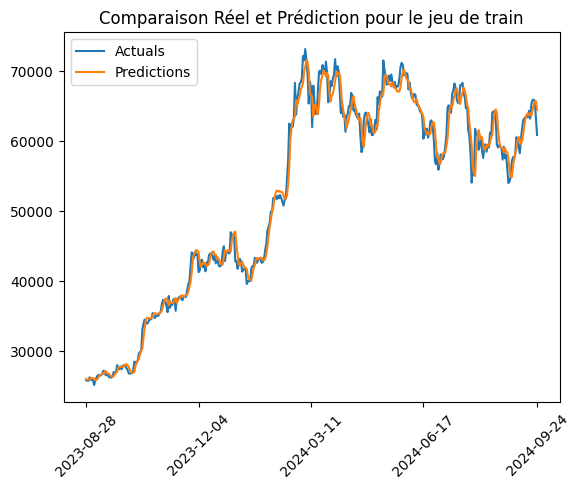

2/2 [==============================] - 1s 6ms/step
X_shape : (49, 7, 1)
y_shape : (49, 1)
Accuracy : 40.816326530612244%
#####VAL#####
           Date      Actual N    Actual N+1  Predictions N+1  Actual UP or DOWN  Predicted UP or DOWN
0   2024-09-25  60805.781250  60649.277344     62328.250000                  0                     1
1   2024-09-26  60649.277344  60752.710938     60931.855469                  1                     1
2   2024-09-27  60752.710938  62086.000000     60397.722656                  1                     0
3   2024-09-28  62086.000000  62058.000000     61012.953125                  0                     0
4   2024-09-29  62058.000000  62819.910156     61604.578125                  1                     0
5   2024-09-30  62819.910156  62224.000000     62482.972656                  0                     0
6   2024-10-01  62224.000000  62160.492188     62652.738281                  0                     1
7   2024-10-02  62160.492188  60636.019531     62538.578

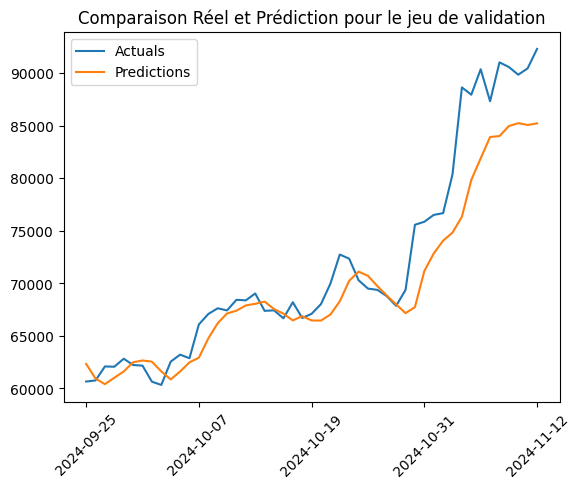

2/2 [==============================] - 1s 6ms/step
X_shape : (50, 7, 1)
y_shape : (50, 1)
Accuracy : 50.877192982456144%
#####TEST#####
           Date      Actual N    Actual N+1  Predictions N+1  Actual UP or DOWN  Predicted UP or DOWN
0   2024-11-13  92310.789062  94286.554688     85869.257812                  1                     0
1   2024-11-14  94286.554688  98317.117188     86969.781250                  1                     0
2   2024-11-15  98317.117188  98891.992188     88894.445312                  1                     0
3   2024-11-16  98891.992188  97672.398438     90349.617188                  0                     0
4   2024-11-17  97672.398438  97900.031250     90748.460938                  1                     0
5   2024-11-18  97900.031250  93010.007812     90864.515625                  0                     0
6   2024-11-19  93010.007812  91965.164062     89174.046875                  0                     0
7   2024-11-20  91965.164062  95863.109375     87113.16

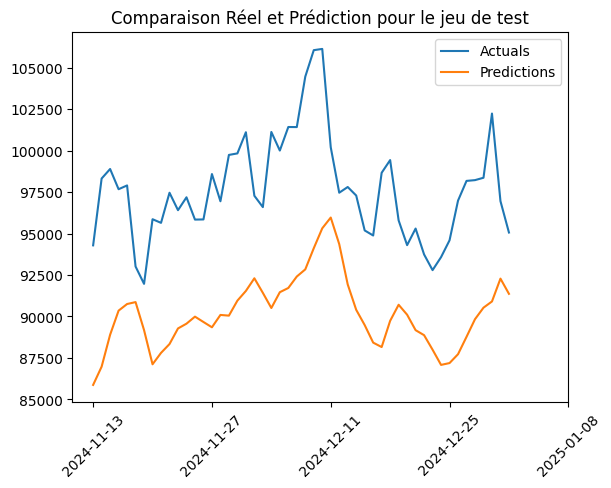

<Figure size 640x480 with 0 Axes>

In [128]:
"is_train : 1 pour Train, 0 pour Test , autre pour val"
for is_train in (1, 2, 0):
    main_analyze_model(is_train)

## CLOSE PRICE SEULEMENT, en 6h (6 heures)

#### Pre processing du dataframe dataset_raw_6h

In [129]:
data_name = "dataset_raw_6h"
# is_one_var = True car une seule variable
is_one_var = True
#On passe la window de 7 à 7*4=28 pour garder une semaine de fenêtre 
WINDOW_SIZE = 28

(date_train, X_train, y_train, date_val, X_val, y_val, date_test, X_test, y_test), scaler_features, scaler_target = main_pre_processing(data_name, is_one_var)
print(f'X_train : {X_train.shape}')
print(f'y_train : {y_train.shape}')
print(f'X_val : {X_val.shape}')
print(f'y_val : {y_val.shape}')
print(f'X_test : {X_test.shape}')
print(f'y_test : {y_test.shape}')

X_train : (1577, 28, 1)
y_train : (1577, 1)
X_val : (197, 28, 1)
y_val : (197, 1)
X_test : (198, 28, 1)
y_test : (198, 1)


#### Training du modèle Close_price-dataset_raw_6h-100

In [130]:
N_EPOCHS = 100
model_name = "Close_price"
full_model_name = model_name+'-'+data_name+'-'+str(N_EPOCHS)

main_training_model(full_model_name, scaler_features, scaler_target, X_train, y_train, X_val, y_val, N_EPOCHS)

Epoch 1/100
49/50 [============================>.] - ETA: 0s - loss: 0.0260 - root_mean_squared_error: 0.1612

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 10s 167ms/step - loss: 0.0258 - root_mean_squared_error: 0.1607 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0837
Epoch 2/100
48/50 [===========================>..] - ETA: 0s - loss: 5.4485e-04 - root_mean_squared_error: 0.0233

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 7s 133ms/step - loss: 5.3666e-04 - root_mean_squared_error: 0.0232 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0378
Epoch 3/100
49/50 [============================>.] - ETA: 0s - loss: 3.2740e-04 - root_mean_squared_error: 0.0181

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 7s 150ms/step - loss: 3.2647e-04 - root_mean_squared_error: 0.0181 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0401
Epoch 4/100
50/50 [==============================] - ETA: 0s - loss: 3.1087e-04 - root_mean_squared_error: 0.0176

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 7s 134ms/step - loss: 3.1087e-04 - root_mean_squared_error: 0.0176 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0398
Epoch 5/100
48/50 [===========================>..] - ETA: 0s - loss: 2.9361e-04 - root_mean_squared_error: 0.0171

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 7s 136ms/step - loss: 2.9162e-04 - root_mean_squared_error: 0.0171 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0347
Epoch 6/100
49/50 [============================>.] - ETA: 0s - loss: 2.7787e-04 - root_mean_squared_error: 0.0167

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 7s 152ms/step - loss: 2.7710e-04 - root_mean_squared_error: 0.0166 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0350
Epoch 7/100
49/50 [============================>.] - ETA: 0s - loss: 2.6527e-04 - root_mean_squared_error: 0.0163

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 7s 136ms/step - loss: 2.6520e-04 - root_mean_squared_error: 0.0163 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0340
Epoch 8/100
49/50 [============================>.] - ETA: 0s - loss: 2.6036e-04 - root_mean_squared_error: 0.0161

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 6s 130ms/step - loss: 2.5991e-04 - root_mean_squared_error: 0.0161 - val_loss: 6.1232e-04 - val_root_mean_squared_error: 0.0247
Epoch 9/100
50/50 [==============================] - ETA: 0s - loss: 2.5651e-04 - root_mean_squared_error: 0.0160

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 8s 156ms/step - loss: 2.5651e-04 - root_mean_squared_error: 0.0160 - val_loss: 9.8041e-04 - val_root_mean_squared_error: 0.0313
Epoch 10/100
49/50 [============================>.] - ETA: 0s - loss: 2.1881e-04 - root_mean_squared_error: 0.0148

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 6s 131ms/step - loss: 2.1822e-04 - root_mean_squared_error: 0.0148 - val_loss: 8.3811e-04 - val_root_mean_squared_error: 0.0290
Epoch 11/100
49/50 [============================>.] - ETA: 0s - loss: 2.0801e-04 - root_mean_squared_error: 0.0144

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 7s 137ms/step - loss: 2.0715e-04 - root_mean_squared_error: 0.0144 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0324
Epoch 12/100
50/50 [==============================] - 1s 29ms/step - loss: 2.4372e-04 - root_mean_squared_error: 0.0156 - val_loss: 7.1761e-04 - val_root_mean_squared_error: 0.0268
Epoch 13/100
50/50 [==============================] - 1s 30ms/step - loss: 2.4225e-04 - root_mean_squared_error: 0.0156 - val_loss: 6.1680e-04 - val_root_mean_squared_error: 0.0248
Epoch 14/100
50/50 [==============================] - ETA: 0s - loss: 1.8910e-04 - root_mean_squared_error: 0.0138

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 7s 149ms/step - loss: 1.8910e-04 - root_mean_squared_error: 0.0138 - val_loss: 5.5536e-04 - val_root_mean_squared_error: 0.0236
Epoch 15/100
50/50 [==============================] - 2s 30ms/step - loss: 1.9008e-04 - root_mean_squared_error: 0.0138 - val_loss: 4.7583e-04 - val_root_mean_squared_error: 0.0218
Epoch 16/100
49/50 [============================>.] - ETA: 0s - loss: 1.8819e-04 - root_mean_squared_error: 0.0137

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 7s 134ms/step - loss: 1.8898e-04 - root_mean_squared_error: 0.0137 - val_loss: 9.5241e-04 - val_root_mean_squared_error: 0.0309
Epoch 17/100
48/50 [===========================>..] - ETA: 0s - loss: 1.7453e-04 - root_mean_squared_error: 0.0132

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 6s 131ms/step - loss: 1.7373e-04 - root_mean_squared_error: 0.0132 - val_loss: 5.0969e-04 - val_root_mean_squared_error: 0.0226
Epoch 18/100
50/50 [==============================] - 1s 30ms/step - loss: 1.7462e-04 - root_mean_squared_error: 0.0132 - val_loss: 7.1150e-04 - val_root_mean_squared_error: 0.0267
Epoch 19/100
50/50 [==============================] - 1s 29ms/step - loss: 1.7461e-04 - root_mean_squared_error: 0.0132 - val_loss: 4.7406e-04 - val_root_mean_squared_error: 0.0218
Epoch 20/100
49/50 [============================>.] - ETA: 0s - loss: 1.6633e-04 - root_mean_squared_error: 0.0129

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 8s 165ms/step - loss: 1.7001e-04 - root_mean_squared_error: 0.0130 - val_loss: 9.5463e-04 - val_root_mean_squared_error: 0.0309
Epoch 21/100
50/50 [==============================] - 1s 29ms/step - loss: 1.8341e-04 - root_mean_squared_error: 0.0135 - val_loss: 4.2787e-04 - val_root_mean_squared_error: 0.0207
Epoch 22/100
50/50 [==============================] - 1s 30ms/step - loss: 1.7145e-04 - root_mean_squared_error: 0.0131 - val_loss: 4.6270e-04 - val_root_mean_squared_error: 0.0215
Epoch 23/100
50/50 [==============================] - ETA: 0s - loss: 1.5331e-04 - root_mean_squared_error: 0.0124

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 7s 135ms/step - loss: 1.5331e-04 - root_mean_squared_error: 0.0124 - val_loss: 4.8765e-04 - val_root_mean_squared_error: 0.0221
Epoch 24/100
50/50 [==============================] - ETA: 0s - loss: 1.4887e-04 - root_mean_squared_error: 0.0122

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 6s 128ms/step - loss: 1.4887e-04 - root_mean_squared_error: 0.0122 - val_loss: 4.8015e-04 - val_root_mean_squared_error: 0.0219
Epoch 25/100
50/50 [==============================] - 1s 30ms/step - loss: 1.5470e-04 - root_mean_squared_error: 0.0124 - val_loss: 7.1395e-04 - val_root_mean_squared_error: 0.0267
Epoch 26/100
50/50 [==============================] - 1s 30ms/step - loss: 1.5150e-04 - root_mean_squared_error: 0.0123 - val_loss: 4.6434e-04 - val_root_mean_squared_error: 0.0215
Epoch 27/100
50/50 [==============================] - 1s 30ms/step - loss: 1.5379e-04 - root_mean_squared_error: 0.0124 - val_loss: 7.9507e-04 - val_root_mean_squared_error: 0.0282
Epoch 28/100
48/50 [===========================>..] - ETA: 0s - loss: 1.4028e-04 - root_mean_squared_error: 0.0118

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 7s 151ms/step - loss: 1.4170e-04 - root_mean_squared_error: 0.0119 - val_loss: 4.0942e-04 - val_root_mean_squared_error: 0.0202
Epoch 29/100
50/50 [==============================] - 2s 30ms/step - loss: 1.6680e-04 - root_mean_squared_error: 0.0129 - val_loss: 5.0842e-04 - val_root_mean_squared_error: 0.0225
Epoch 30/100
50/50 [==============================] - 1s 29ms/step - loss: 1.4671e-04 - root_mean_squared_error: 0.0121 - val_loss: 8.2089e-04 - val_root_mean_squared_error: 0.0287
Epoch 31/100
50/50 [==============================] - 1s 30ms/step - loss: 1.4484e-04 - root_mean_squared_error: 0.0120 - val_loss: 4.4235e-04 - val_root_mean_squared_error: 0.0210
Epoch 32/100
50/50 [==============================] - 1s 30ms/step - loss: 1.5106e-04 - root_mean_squared_error: 0.0123 - val_loss: 4.7660e-04 - val_root_mean_squared_error: 0.0218
Epoch 33/100
49/50 [============================>.] - ETA: 0s - loss: 1.4068e-04 - root_mean_squared_error:

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 7s 132ms/step - loss: 1.4048e-04 - root_mean_squared_error: 0.0119 - val_loss: 4.6958e-04 - val_root_mean_squared_error: 0.0217
Epoch 34/100
48/50 [===========================>..] - ETA: 0s - loss: 1.3788e-04 - root_mean_squared_error: 0.0117

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 6s 131ms/step - loss: 1.3733e-04 - root_mean_squared_error: 0.0117 - val_loss: 6.1987e-04 - val_root_mean_squared_error: 0.0249
Epoch 35/100
48/50 [===========================>..] - ETA: 0s - loss: 1.3094e-04 - root_mean_squared_error: 0.0114

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 8s 163ms/step - loss: 1.3222e-04 - root_mean_squared_error: 0.0115 - val_loss: 3.7333e-04 - val_root_mean_squared_error: 0.0193
Epoch 36/100
50/50 [==============================] - 1s 30ms/step - loss: 1.4194e-04 - root_mean_squared_error: 0.0119 - val_loss: 6.4402e-04 - val_root_mean_squared_error: 0.0254
Epoch 37/100
49/50 [============================>.] - ETA: 0s - loss: 1.2971e-04 - root_mean_squared_error: 0.0114

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 6s 131ms/step - loss: 1.2976e-04 - root_mean_squared_error: 0.0114 - val_loss: 4.1782e-04 - val_root_mean_squared_error: 0.0204
Epoch 38/100
49/50 [============================>.] - ETA: 0s - loss: 1.2597e-04 - root_mean_squared_error: 0.0112

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 7s 150ms/step - loss: 1.2601e-04 - root_mean_squared_error: 0.0112 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0328
Epoch 39/100
50/50 [==============================] - 1s 30ms/step - loss: 1.2947e-04 - root_mean_squared_error: 0.0114 - val_loss: 6.2983e-04 - val_root_mean_squared_error: 0.0251
Epoch 40/100
50/50 [==============================] - 2s 30ms/step - loss: 1.4038e-04 - root_mean_squared_error: 0.0118 - val_loss: 4.6063e-04 - val_root_mean_squared_error: 0.0215
Epoch 41/100
49/50 [============================>.] - ETA: 0s - loss: 1.2416e-04 - root_mean_squared_error: 0.0111

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 6s 131ms/step - loss: 1.2422e-04 - root_mean_squared_error: 0.0111 - val_loss: 3.8074e-04 - val_root_mean_squared_error: 0.0195
Epoch 42/100
49/50 [============================>.] - ETA: 0s - loss: 1.2157e-04 - root_mean_squared_error: 0.0110

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 6s 128ms/step - loss: 1.2208e-04 - root_mean_squared_error: 0.0110 - val_loss: 7.7926e-04 - val_root_mean_squared_error: 0.0279
Epoch 43/100
50/50 [==============================] - ETA: 0s - loss: 1.2066e-04 - root_mean_squared_error: 0.0110

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 8s 159ms/step - loss: 1.2066e-04 - root_mean_squared_error: 0.0110 - val_loss: 6.6718e-04 - val_root_mean_squared_error: 0.0258
Epoch 44/100
49/50 [============================>.] - ETA: 0s - loss: 1.1938e-04 - root_mean_squared_error: 0.0109

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 7s 133ms/step - loss: 1.1919e-04 - root_mean_squared_error: 0.0109 - val_loss: 4.3567e-04 - val_root_mean_squared_error: 0.0209
Epoch 45/100
50/50 [==============================] - 2s 30ms/step - loss: 1.4284e-04 - root_mean_squared_error: 0.0120 - val_loss: 6.1164e-04 - val_root_mean_squared_error: 0.0247
Epoch 46/100
50/50 [==============================] - 2s 30ms/step - loss: 1.1999e-04 - root_mean_squared_error: 0.0110 - val_loss: 4.6834e-04 - val_root_mean_squared_error: 0.0216
Epoch 47/100
50/50 [==============================] - 1s 29ms/step - loss: 1.3008e-04 - root_mean_squared_error: 0.0114 - val_loss: 4.9875e-04 - val_root_mean_squared_error: 0.0223
Epoch 48/100
50/50 [==============================] - 1s 30ms/step - loss: 1.2876e-04 - root_mean_squared_error: 0.0113 - val_loss: 7.0203e-04 - val_root_mean_squared_error: 0.0265
Epoch 49/100
50/50 [==============================] - ETA: 0s - loss: 1.0890e-04 - root_mean_squared_error:

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 7s 139ms/step - loss: 1.0890e-04 - root_mean_squared_error: 0.0104 - val_loss: 2.9979e-04 - val_root_mean_squared_error: 0.0173
Epoch 50/100
50/50 [==============================] - 2s 30ms/step - loss: 1.2265e-04 - root_mean_squared_error: 0.0111 - val_loss: 4.1090e-04 - val_root_mean_squared_error: 0.0203
Epoch 51/100
50/50 [==============================] - 1s 30ms/step - loss: 1.2815e-04 - root_mean_squared_error: 0.0113 - val_loss: 4.8796e-04 - val_root_mean_squared_error: 0.0221
Epoch 52/100
48/50 [===========================>..] - ETA: 0s - loss: 1.0392e-04 - root_mean_squared_error: 0.0102

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 8s 155ms/step - loss: 1.0496e-04 - root_mean_squared_error: 0.0102 - val_loss: 2.8916e-04 - val_root_mean_squared_error: 0.0170
Epoch 53/100
49/50 [============================>.] - ETA: 0s - loss: 1.0439e-04 - root_mean_squared_error: 0.0102

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 6s 131ms/step - loss: 1.0454e-04 - root_mean_squared_error: 0.0102 - val_loss: 2.9063e-04 - val_root_mean_squared_error: 0.0170
Epoch 54/100
50/50 [==============================] - 1s 29ms/step - loss: 1.1139e-04 - root_mean_squared_error: 0.0106 - val_loss: 3.1818e-04 - val_root_mean_squared_error: 0.0178
Epoch 55/100
50/50 [==============================] - 1s 30ms/step - loss: 1.0899e-04 - root_mean_squared_error: 0.0104 - val_loss: 3.7636e-04 - val_root_mean_squared_error: 0.0194
Epoch 56/100
50/50 [==============================] - 1s 30ms/step - loss: 1.1818e-04 - root_mean_squared_error: 0.0109 - val_loss: 5.8281e-04 - val_root_mean_squared_error: 0.0241
Epoch 57/100
49/50 [============================>.] - ETA: 0s - loss: 1.0028e-04 - root_mean_squared_error: 0.0100

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 6s 129ms/step - loss: 1.0015e-04 - root_mean_squared_error: 0.0100 - val_loss: 5.1943e-04 - val_root_mean_squared_error: 0.0228
Epoch 58/100
49/50 [============================>.] - ETA: 0s - loss: 1.0022e-04 - root_mean_squared_error: 0.0100

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 8s 154ms/step - loss: 9.9788e-05 - root_mean_squared_error: 0.0100 - val_loss: 4.5120e-04 - val_root_mean_squared_error: 0.0212
Epoch 59/100
49/50 [============================>.] - ETA: 0s - loss: 9.8438e-05 - root_mean_squared_error: 0.0099

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 7s 145ms/step - loss: 9.8946e-05 - root_mean_squared_error: 0.0099 - val_loss: 3.9663e-04 - val_root_mean_squared_error: 0.0199
Epoch 60/100
50/50 [==============================] - 1s 29ms/step - loss: 9.9317e-05 - root_mean_squared_error: 0.0100 - val_loss: 9.4643e-04 - val_root_mean_squared_error: 0.0308
Epoch 61/100
50/50 [==============================] - 1s 29ms/step - loss: 1.5044e-04 - root_mean_squared_error: 0.0123 - val_loss: 4.9385e-04 - val_root_mean_squared_error: 0.0222
Epoch 62/100
49/50 [============================>.] - ETA: 0s - loss: 9.7443e-05 - root_mean_squared_error: 0.0099

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 6s 129ms/step - loss: 9.7003e-05 - root_mean_squared_error: 0.0098 - val_loss: 2.8598e-04 - val_root_mean_squared_error: 0.0169
Epoch 63/100
50/50 [==============================] - 2s 30ms/step - loss: 1.0766e-04 - root_mean_squared_error: 0.0104 - val_loss: 4.1763e-04 - val_root_mean_squared_error: 0.0204
Epoch 64/100
50/50 [==============================] - 1s 30ms/step - loss: 1.3256e-04 - root_mean_squared_error: 0.0115 - val_loss: 9.2405e-04 - val_root_mean_squared_error: 0.0304
Epoch 65/100
50/50 [==============================] - 1s 30ms/step - loss: 1.0255e-04 - root_mean_squared_error: 0.0101 - val_loss: 3.8679e-04 - val_root_mean_squared_error: 0.0197
Epoch 66/100
50/50 [==============================] - 1s 29ms/step - loss: 9.9777e-05 - root_mean_squared_error: 0.0100 - val_loss: 3.7016e-04 - val_root_mean_squared_error: 0.0192
Epoch 67/100
50/50 [==============================] - 1s 29ms/step - loss: 1.0334e-04 - root_mean_squared_e

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 8s 165ms/step - loss: 9.2342e-05 - root_mean_squared_error: 0.0096 - val_loss: 2.1765e-04 - val_root_mean_squared_error: 0.0148
Epoch 71/100
50/50 [==============================] - 1s 30ms/step - loss: 9.9537e-05 - root_mean_squared_error: 0.0100 - val_loss: 4.7986e-04 - val_root_mean_squared_error: 0.0219
Epoch 72/100
50/50 [==============================] - 1s 29ms/step - loss: 1.1317e-04 - root_mean_squared_error: 0.0106 - val_loss: 7.2495e-04 - val_root_mean_squared_error: 0.0269
Epoch 73/100
50/50 [==============================] - 1s 30ms/step - loss: 9.6974e-05 - root_mean_squared_error: 0.0098 - val_loss: 3.5024e-04 - val_root_mean_squared_error: 0.0187
Epoch 74/100
49/50 [============================>.] - ETA: 0s - loss: 9.1394e-05 - root_mean_squared_error: 0.0096

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 7s 139ms/step - loss: 9.1583e-05 - root_mean_squared_error: 0.0096 - val_loss: 5.0898e-04 - val_root_mean_squared_error: 0.0226
Epoch 75/100
50/50 [==============================] - 1s 30ms/step - loss: 1.1162e-04 - root_mean_squared_error: 0.0106 - val_loss: 3.5672e-04 - val_root_mean_squared_error: 0.0189
Epoch 76/100
50/50 [==============================] - ETA: 0s - loss: 8.9985e-05 - root_mean_squared_error: 0.0095

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 8s 158ms/step - loss: 8.9985e-05 - root_mean_squared_error: 0.0095 - val_loss: 3.2228e-04 - val_root_mean_squared_error: 0.0180
Epoch 77/100
50/50 [==============================] - 1s 30ms/step - loss: 9.5867e-05 - root_mean_squared_error: 0.0098 - val_loss: 3.0776e-04 - val_root_mean_squared_error: 0.0175
Epoch 78/100
50/50 [==============================] - 2s 30ms/step - loss: 9.4410e-05 - root_mean_squared_error: 0.0097 - val_loss: 6.4603e-04 - val_root_mean_squared_error: 0.0254
Epoch 79/100
50/50 [==============================] - 1s 30ms/step - loss: 1.0426e-04 - root_mean_squared_error: 0.0102 - val_loss: 4.2302e-04 - val_root_mean_squared_error: 0.0206
Epoch 80/100
50/50 [==============================] - 1s 29ms/step - loss: 1.0894e-04 - root_mean_squared_error: 0.0104 - val_loss: 4.0464e-04 - val_root_mean_squared_error: 0.0201
Epoch 81/100
48/50 [===========================>..] - ETA: 0s - loss: 8.8722e-05 - root_mean_squared_error:

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 6s 129ms/step - loss: 8.7968e-05 - root_mean_squared_error: 0.0094 - val_loss: 4.3584e-04 - val_root_mean_squared_error: 0.0209
Epoch 82/100
50/50 [==============================] - 1s 30ms/step - loss: 9.6441e-05 - root_mean_squared_error: 0.0098 - val_loss: 8.6155e-04 - val_root_mean_squared_error: 0.0294
Epoch 83/100
50/50 [==============================] - 1s 30ms/step - loss: 1.0915e-04 - root_mean_squared_error: 0.0104 - val_loss: 7.2405e-04 - val_root_mean_squared_error: 0.0269
Epoch 84/100
50/50 [==============================] - 1s 29ms/step - loss: 9.9141e-05 - root_mean_squared_error: 0.0100 - val_loss: 3.8081e-04 - val_root_mean_squared_error: 0.0195
Epoch 85/100
50/50 [==============================] - 2s 30ms/step - loss: 1.0452e-04 - root_mean_squared_error: 0.0102 - val_loss: 5.1378e-04 - val_root_mean_squared_error: 0.0227
Epoch 86/100
49/50 [============================>.] - ETA: 0s - loss: 8.7076e-05 - root_mean_squared_error:

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 7s 138ms/step - loss: 8.6811e-05 - root_mean_squared_error: 0.0093 - val_loss: 3.0379e-04 - val_root_mean_squared_error: 0.0174
Epoch 87/100
50/50 [==============================] - ETA: 0s - loss: 8.3686e-05 - root_mean_squared_error: 0.0091

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 8s 168ms/step - loss: 8.3686e-05 - root_mean_squared_error: 0.0091 - val_loss: 4.2606e-04 - val_root_mean_squared_error: 0.0206
Epoch 88/100
50/50 [==============================] - 1s 29ms/step - loss: 9.7471e-05 - root_mean_squared_error: 0.0099 - val_loss: 3.4204e-04 - val_root_mean_squared_error: 0.0185
Epoch 89/100
50/50 [==============================] - 1s 29ms/step - loss: 1.1415e-04 - root_mean_squared_error: 0.0107 - val_loss: 2.5548e-04 - val_root_mean_squared_error: 0.0160
Epoch 90/100
50/50 [==============================] - ETA: 0s - loss: 8.3675e-05 - root_mean_squared_error: 0.0091

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 7s 137ms/step - loss: 8.3675e-05 - root_mean_squared_error: 0.0091 - val_loss: 2.4513e-04 - val_root_mean_squared_error: 0.0157
Epoch 91/100
50/50 [==============================] - 1s 30ms/step - loss: 8.9651e-05 - root_mean_squared_error: 0.0095 - val_loss: 2.5313e-04 - val_root_mean_squared_error: 0.0159
Epoch 92/100
49/50 [============================>.] - ETA: 0s - loss: 8.1017e-05 - root_mean_squared_error: 0.0090

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_6h-100/assets


50/50 [==============================] - 7s 139ms/step - loss: 8.1147e-05 - root_mean_squared_error: 0.0090 - val_loss: 3.4725e-04 - val_root_mean_squared_error: 0.0186
Epoch 93/100
50/50 [==============================] - 1s 29ms/step - loss: 8.8426e-05 - root_mean_squared_error: 0.0094 - val_loss: 3.8381e-04 - val_root_mean_squared_error: 0.0196
Epoch 94/100
50/50 [==============================] - 1s 29ms/step - loss: 8.4887e-05 - root_mean_squared_error: 0.0092 - val_loss: 3.3180e-04 - val_root_mean_squared_error: 0.0182
Epoch 95/100
50/50 [==============================] - 2s 30ms/step - loss: 9.0000e-05 - root_mean_squared_error: 0.0095 - val_loss: 3.5821e-04 - val_root_mean_squared_error: 0.0189
Epoch 96/100
50/50 [==============================] - 1s 30ms/step - loss: 8.7316e-05 - root_mean_squared_error: 0.0093 - val_loss: 5.9111e-04 - val_root_mean_squared_error: 0.0243
Epoch 97/100
50/50 [==============================] - 1s 30ms/step - loss: 1.0160e-04 - root_mean_squared_e

#### Analyse du modèle Close_price-dataset_raw_6h-100

In [131]:
def analyze(date, X, y, predictions):
    """
    """
    df_analyze = pd.concat([
                            pd.DataFrame(date), 
                            pd.DataFrame(X[:, WINDOW_SIZE-1, 0]), 
                            pd.DataFrame(y.reshape(-1)), 
                            pd.DataFrame(predictions)
                            ], axis=1)
    
    df_analyze.columns = ['Date', 'Actual N', 'Actual N+1', 'Predictions N+1']

    df_analyze_minuit = df_analyze[pd.to_datetime(df_analyze['Date']).dt.time == pd.Timestamp('00:00:00').time()]

    df_analyze_minuit['Actual UP or DOWN'] = pd.DataFrame((df_analyze_minuit['Actual N+1'] > df_analyze_minuit['Actual N']).astype(int))
    df_analyze_minuit['Predicted UP or DOWN'] = pd.DataFrame((df_analyze_minuit['Predictions N+1'] > df_analyze_minuit['Actual N']).astype(int))

    cm = confusion_matrix(df_analyze_minuit['Actual UP or DOWN'], df_analyze_minuit['Predicted UP or DOWN'])
    acc = cm[0][0] + cm[1][1]
    tot = cm.sum()
    print(f'Accuracy : {acc/tot*100}%')
    cm_df = pd.DataFrame(cm, index=['Actual DOWN', 'Actual UP'], columns=['Predicted DOWN', 'Predicted UP'])
    
    return df_analyze_minuit, cm_df

def main_analyze_model(is_train):
    model_name = "Close_price-dataset_raw_6h-100"
    data_name = model_name.split('-')[1]
    loaded_model = load(model_name)

    (date_train, X_train, y_train, date_val, X_val, y_val, date_test, X_test, y_test), scaler_features, scaler_target = main_pre_processing(data_name, is_one_var=True)

    analyze_for_data(loaded_model, scaler_features, scaler_target, date_train, X_train, y_train, date_test, X_test, y_test, date_val, X_val, y_val, is_train)

50/50 [==============================] - 1s 9ms/step
X_shape : (1577, 28, 1)
y_shape : (1577, 1)
Accuracy : 52.151898734177216%
#####TRAIN#####
                    Date      Actual N    Actual N+1  Predictions N+1  Actual UP or DOWN  Predicted UP or DOWN
0   2023-08-28 00:00:00  25971.208984  25934.439453     25993.750000                  0                     1
4   2023-08-29 00:00:00  25826.021484  25733.310547     25925.316406                  0                     1
8   2023-08-30 00:00:00  25792.101562  25746.548828     25864.382812                  0                     1
12  2023-08-31 00:00:00  25759.951172  25788.919922     25864.894531                  1                     1
16  2023-09-01 00:00:00  26255.001953  26239.429688     26137.166016                  0                     0
20  2023-09-02 00:00:00  25910.500000  25844.919922     25968.060547                  0                     1
24  2023-09-03 00:00:00  25901.609375  25847.810547     25958.636719                 

/tmp/ipykernel_3730955/4104383911.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analyze_minuit['Actual UP or DOWN'] = pd.DataFrame((df_analyze_minuit['Actual N+1'] > df_analyze_minuit['Actual N']).astype(int))
/tmp/ipykernel_3730955/4104383911.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analyze_minuit['Predicted UP or DOWN'] = pd.DataFrame((df_analyze_minuit['Predictions N+1'] > df_analyze_minuit['Actual N']).astype(int))


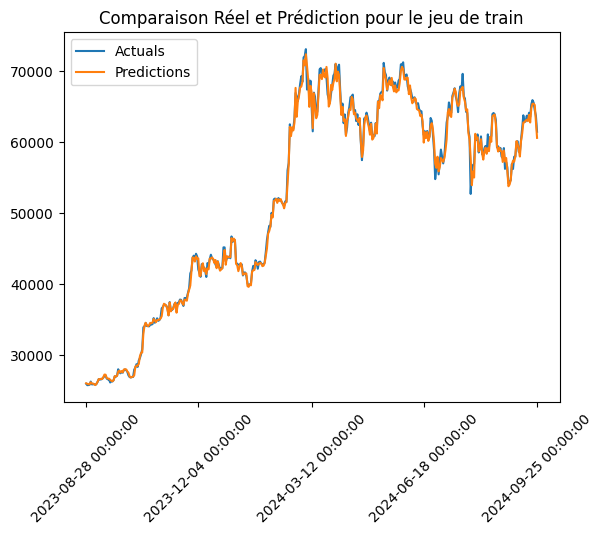

7/7 [==============================] - 1s 9ms/step
X_shape : (197, 28, 1)
y_shape : (197, 1)
Accuracy : 38.775510204081634%
#####VAL#####
                    Date      Actual N    Actual N+1  Predictions N+1  Actual UP or DOWN  Predicted UP or DOWN
3   2024-09-26 00:00:00  60649.281250  61176.011719     60479.179688                  1                     0
7   2024-09-27 00:00:00  60752.714844  61224.339844     60414.769531                  1                     0
11  2024-09-28 00:00:00  62086.003906  62149.472656     61774.335938                  1                     0
15  2024-09-29 00:00:00  62058.000000  61938.507812     61753.675781                  0                     0
19  2024-09-30 00:00:00  62819.910156  63380.011719     62507.214844                  1                     0
23  2024-10-01 00:00:00  62224.003906  62517.351562     62143.347656                  1                     0
27  2024-10-02 00:00:00  62160.492188  62524.093750     61899.097656                  1    

/tmp/ipykernel_3730955/4104383911.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analyze_minuit['Actual UP or DOWN'] = pd.DataFrame((df_analyze_minuit['Actual N+1'] > df_analyze_minuit['Actual N']).astype(int))
/tmp/ipykernel_3730955/4104383911.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analyze_minuit['Predicted UP or DOWN'] = pd.DataFrame((df_analyze_minuit['Predictions N+1'] > df_analyze_minuit['Actual N']).astype(int))


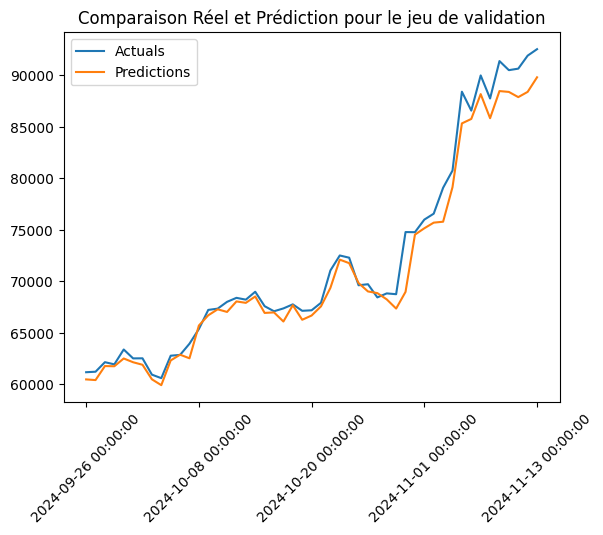

7/7 [==============================] - 1s 9ms/step
X_shape : (198, 28, 1)
y_shape : (198, 1)
Accuracy : 55.35714285714286%
#####TEST#####
                    Date      Actual N     Actual N+1  Predictions N+1  Actual UP or DOWN  Predicted UP or DOWN
2   2024-11-14 00:00:00  94286.562500   97328.000000     91340.234375                  1                     0
6   2024-11-15 00:00:00  98317.125000   98790.968750     94707.226562                  1                     0
10  2024-11-16 00:00:00  98892.000000   98755.148438     95546.554688                  0                     0
14  2024-11-17 00:00:00  97672.398438   98264.437500     94747.398438                  1                     0
18  2024-11-18 00:00:00  97900.039062   98082.695312     94604.695312                  1                     0
22  2024-11-19 00:00:00  93010.015625   94647.960938     90930.937500                  1                     0
26  2024-11-20 00:00:00  91965.164062   92768.015625     89916.234375               

/tmp/ipykernel_3730955/4104383911.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analyze_minuit['Actual UP or DOWN'] = pd.DataFrame((df_analyze_minuit['Actual N+1'] > df_analyze_minuit['Actual N']).astype(int))
/tmp/ipykernel_3730955/4104383911.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analyze_minuit['Predicted UP or DOWN'] = pd.DataFrame((df_analyze_minuit['Predictions N+1'] > df_analyze_minuit['Actual N']).astype(int))


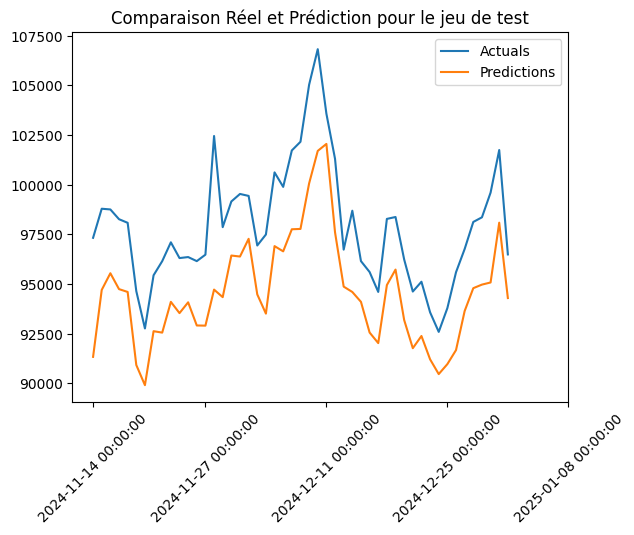

<Figure size 640x480 with 0 Axes>

In [132]:
"is_train : 1 pour Train, 0 pour Test , autre pour val"
for is_train in (1, 2, 0):
    main_analyze_model(is_train)